In [1]:
#█▀▀ █▀▀ █▄ █ █▀▀ █▀█ ▄▀█ █   
#█▄█ ██▄ █ ▀█ ██▄ █▀▄ █▀█ █▄▄ 
#
# NOTHING HERE CHANGES ANYTHING BUT ERRORS WILL OCCUR IN GLOBAL VARS IF ITS NOT SET
plotting = True
process_ywl = True
process_grn = True
process_fhv = True
process_hvf = True
testing = False
start_month = 3        #testing var default 2
number_of_months = 5   #testing var default 11
start_day = 60         #testing var default 32ish
number_of_days = 100     

In [2]:
#█▀█ █   █▀█ ▀█▀ ▀█▀ █ █▄ █ █▀▀    █   █ █▄▄ █▀ 
#█▀▀ █▄▄ █▄█  █   █  █ █ ▀█ █▄█    █▄▄ █ █▄█ ▄█ 
# #setting up libs

import numpy as np
from scipy.stats import entropy
from math import e

from collections import OrderedDict

import random as random
np.random.seed(1)
from pprint import pprint

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.show() 
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.show() 
plt.rcParams.update({'font.size': 22})

plt.rcParams['axes.grid'] = False

from scipy.stats import mode, chi2_contingency, pearsonr 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import datasets
from sklearn import svm

import warnings

warnings.filterwarnings("ignore")

In [3]:
#  ██████╗  ██╗       ██████╗  ██████╗   █████╗  ██╗
# ██╔════╝  ██║      ██╔═══██╗ ██╔══██╗ ██╔══██╗ ██║
# ██║  ███╗ ██║      ██║   ██║ ██████╔╝ ███████║ ██║
# ██║   ██║ ██║      ██║   ██║ ██╔══██╗ ██╔══██║ ██║
# ╚██████╔╝ ███████╗ ╚██████╔╝ ██████╔╝ ██║  ██║ ███████╗
#  ╚═════╝  ╚══════╝  ╚═════╝  ╚═════╝  ╚═╝  ╚═╝ ╚══════╝
# ██╗   ██╗  █████╗  ██████╗  ███████╗
# ██║   ██║ ██╔══██╗ ██╔══██╗ ██╔════╝
# ██║   ██║ ███████║ ██████╔╝ ███████╗
# ╚██╗ ██╔╝ ██╔══██║ ██╔══██╗ ╚════██║
#  ╚████╔╝  ██║  ██║ ██║  ██║ ███████║
#   ╚═══╝   ╚═╝  ╚═╝ ╚═╝  ╚═╝ ╚══════╝
# v3.2.0
# global variabels which can be tweeked

# █▀▄ ▄▀█ ▀█▀ ▄▀█    █▀▄ █ █▀█
# █▄▀ █▀█  █  █▀█    █▄▀ █ █▀▄
#

# main data directory
download_dir = "../../raw_data/"

#where the pre processed data goes
processed_dir = "../../processed_data/" 

#where the tallying data goes
tallied_dir = "../../tallied_data/" 

# intermediate file names
processed_data_file = "_processed_data_"
tally_s1_file = "taxi_data_tallyed_s1.csv"
tally_s2_file = "taxi_data_tallyed_s2.csv"
tally_s3_file = "taxi_data_tallyed_s3.csv"


# █    ▀  █▀▀▄ █▀▀█ █▀▀█ █▀▀█ █  █ █▀▀
# █   ▀█▀ █▀▀▄ █▄▄▀ █▄▄█ █▄▄▀ █▄▄█ ▀▀█
# ▀▀▀ ▀▀▀ ▀▀▀  ▀ ▀▀ ▀  ▀ ▀ ▀▀ ▄▄▄█ ▀▀▀
# imporint libarys used throughout

import time
import datetime

import pandas as pd
from numpy import log, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from math import e

import os.path
import os
from os.path import getsize
from urllib.request import urlretrieve

from pyspark.sql.functions import rand
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

import warnings

# variable for skipping all the plotting code for debugging processing
start_time = time.perf_counter()
start_time_og = time.perf_counter()


# ▀█▀ ▄▀█ ▀▄▀ █    █▀▄ ▄▀█ ▀█▀ ▄▀█
#  █  █▀█ █ █ █    █▄▀ █▀█  █  █▀█
#

# file location
file_base = "_tripdata_"

# indexs for each of the main data set types
ywl_i = 0
grn_i = 1
fhv_i = 2
hvf_i = 3

# used to identify which taxis to process
process_taxi = [process_ywl, process_grn, process_fhv, process_hvf]

# names related to each cab type in order
taxi_file_names = ["yellow", "green", "fhv", "fhvhv"]
full_names = ["yellow cabs", "green cabs",
              "for higher vheciles", "for higher high volume"]

#months in a year
months_of_year = ['January', 'February', 'March', 'April', 'May',
                  'June', 'July', 'August', 'September', 'October', 'November', 'December']

# column names for each cab type in order
column_names = [
    ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
     'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
     'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
     'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
     'total_amount', 'congestion_surcharge'],
    ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
     'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
     'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
     'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
     'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
    ['dispatching_base_num', 'pickup_datetime', 'dropoff_datetime',
     'PULocationID', 'DOLocationID', 'SR_Flag'],
    ['hvfhs_license_num', 'dispatching_base_num', 'pickup_datetime',
     'dropoff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag']
]

# 2018 fhv files which was giving me trouble so added this schema for it
bad_fhv_schema = [2, 2018, ['Pickup_DateTime', 'DropOff_datetime',
                            'PULocationID', 'DOLocationID', 'SR_Flag',
                            'dispatching_base_number']]


# aliases for pickup time and dropoff time
pickup_time = ['tpep_pickup_datetime', 'lpep_pickup_datetime',
               'pickup_datetime', 'pickup_datetime', 'Pickup_DateTime']
dropoff_time = ['tpep_dropoff_datetime', 'lpep_dropoff_datetime',
                'dropoff_datetime', 'dropoff_datetime', 'DropOff_datetime']

# irrelavent collumns that can be dropped
irrelavent_columns = ['dispatching_base_number', 'DOtime', 'hvfhs_license_num',
                      'dispatching_base_num', 'VendorID', 'store_and_fwd_flag',
                      'extra', 'MTA_tax', 'improvement_surcharge',
                      'tip_amount', 'tolls_amount', 'ehail_fee',
                      'improvement_surcharge', 'congestion_surcharge']

# array, for all the taxi count colls
all_taxi_cols = [
                "2019_night",
                "2019_morn",
                "2019_arvo",
                "2019_even",
                "2020_night",
                "2020_morn",
                "2020_arvo",
                "2020_even"
                ]

# array for 2020 taxi count colls
taxi_cols_2020 = [
                 "2020_night",
                 "2020_morn",
                 "2020_arvo",
                 "2020_even"]


# ▀█▀ ▄▀█ ▀▄▀ █    █   █▀█ █▀▀ ▄▀█ ▀█▀ █ █▀█ █▄ █ █▀
#  █  █▀█ █ █ █    █▄▄ █▄█ █▄▄ █▀█  █  █ █▄█ █ ▀█ ▄█
#

# location processing variables
# locations that will be removed as considered invalid
bad_locations = [1, 132, 138, 264, 265]

# location of the location id file
location_file = "taxi+_zone_lookup.csv"

# list of boroughs names as in the location file
boroughs_locations = ["Bronx", "Brooklyn", "Manhattan", "Queens",
                      "Staten Island", "EWR", "Unknown"]


# █▀▄ █▀█ █ █ █ █▄ █ █   █▀█ ▄▀█ █▀▄
# █▄▀ █▄█ ▀▄▀▄▀ █ ▀█ █▄▄ █▄█ █▀█ █▄▀
#

# taxi data base url
taxi_url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/"

# covid cases
covid_url = "https://data.cityofnewyork.us/api/views/rc75-m7u3/rows.csv?accessType=DOWNLOAD"

# location data
location_url = "https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv"

# █▀▄ ▄▀█ ▀█▀ █▀▀    █▀▄ █▀▀ █▀▀ █▀
# █▄▀ █▀█  █  ██▄    █▄▀ ██▄ █▀  ▄█
#
months_in_year = 12

# years of data used
years = [2019, 2020]

# feb 2019 was when fhvhv file started
fhvhv_started = [2, 2019]

# late feb 2020 was when the first case of covid was observed in NYC
covid_started = [2, 2020]

# preprocessing arrays

# hours each day to seperate each count
day_time_breakdown = [0, 6, 12, 18]

# day of the year covid started on
covid_start_day = int(datetime.datetime.strptime(
    " ".join([str(int) for int in covid_started]),
    "%m %Y").__format__("%j"))

# pretty self explanitory
days_in_2020 = 366


# █▀█ █ █ ▀█▀ █   █ █▀▀ █▀█ █▀
# █▄█ █▄█  █  █▄▄ █ ██▄ █▀▄ ▄█
# values for calculating outliers

# all vals must be withing the .99 percent of data
outlier_percent = (1 - .99) / 2

# buffer for graphing and removing outliers from graphs
fare_amount_graph_buffer = 15

# accuracy when calculating the percentile
percentile_accuracy = 0.00001


# █▀▀ █▀█ █ █ █ █▀▄    █▀▄ █▀▀ █▀▀ █▀
# █▄▄ █▄█ ▀▄▀ █ █▄▀    █▄▀ ██▄ █▄▄ ▄█
#

# files
covid_restrictions_file = "covid_restrictions.csv"
covid_cases_file = "COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv"

# list of boroughs as named in the covid file (same order)
covid_boroughs = ["bx", "bk", "mn", "qn", "si"]


# █▀ █▀▀ ▀█▀ █ █ █▀█    █▀▀ █▀█ █▄ █ █▀▄ █ ▀█▀ █ █▀█ █▄ █ █▀
# ▄█ ██▄  █  █▄█ █▀▀    █▄▄ █▄█ █ ▀█ █▄▀ █  █  █ █▄█ █ ▀█ ▄█
#

# plotting is using a yellow data set so must skip plotting if no yellow
if plotting:
    if not (process_taxi[ywl_i] and process_taxi[grn_i]):
        plotting = False


# if in a testing mode, sets up variables so file processes correctly
if testing:

    # changes the download dir to not overwrite data
    download_dir += "../test_download/"

    # changes some timing variabels to anaylise only what is needed for testing
    covid_started[0] = start_month
    months_in_year = start_month + number_of_months - 1
    graph_month = start_month
    days_in_2020 = start_day + number_of_days
    days_in_common = days_in_2020
else:

    # i not testing graphing month is 5 (so may)
    graph_month = 5


# █▀▄▀█ █ █▀ █▀▀    █▀▀ █ █ █▄ █ █▀▀
# █ ▀ █ █ ▄█ █▄▄    █▀  █▄█ █ ▀█ █▄▄
# specialized functions

# sets seed for when its used
seed = 1


# log function to deal with integer count data, added conditions to set
# any negative or 0 values to be 0
def logf(x):
    return (log(x) if x > 0 else 0)


# applys a log log others 0
def loglogf(x):
    return (log(log(x)) if x > e else 0)


# applys log log to an array
def loglogfa(arr):
    return [loglogf(x) for x in arr]

In [4]:
#█▀▀ ▄▀█ █▀ █▀▀ █▀ 
#█▄▄ █▀█ ▄█ ██▄ ▄█ 
# #importing covid case data
covid_cases = pd.read_csv(download_dir + covid_cases_file)

#makes the names of columns lowercase
covid_cases.columns = covid_cases.columns.str.lower()

#makes the date column datetime object
covid_cases['date_of_interest'] = covid_cases['date_of_interest']\
    .transform(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

#renaming some badly named columns
covid_cases['probable_death_count'] = covid_cases['death_count_probable']
covid_cases['hospitalized_count_7day_avg'] = covid_cases['hosp_count_7day_avg']
covid_cases = covid_cases.drop(['death_count_probable','hosp_count_7day_avg'],axis=1)

In [5]:

#main data directory
data_dir = "/mnt/e/2021/Applied Data Science/Project 1/Data/"

#list of boroughs names as in the location file
boroughs = ["Bronx","Brooklyn","Manhattan","Queens","Staten Island"]

#reads the tallied file
df = pd.read_csv(tallied_dir + tally_s2_file)


In [6]:
#checks file read fine
df

,Unnamed: 0,day_year,day_week,week,borough,fhv,2019_night,2019_morn,2019_arvo,2019_even,...,borough_case_count_7day_avg,borough_all_case_count_7day_avg,borough_hospitalized_count_7day_avg,borough_death_count_7day_avg,borough_all_death_count_7day_avg,stadium_capcity,restaurants,high_schools,indoor_religious,phase_1
0,0,32,6,4,0,0,1.676556,1.860428,1.884553,1.810529,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,1,32,6,4,0,1,2.293099,2.309731,2.338324,2.366162,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2,32,6,4,1,0,2.112605,2.052718,2.136567,2.166455,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
3,3,32,6,4,1,1,2.394665,2.390935,2.436074,2.467458,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
4,4,32,6,4,2,0,2.374448,2.400022,2.454497,2.454562,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,3315,363,1,52,2,1,2.340907,2.421726,2.470082,2.459379,...,1.806491,1.847767,1.276345,0.475885,0.475885,0.0,0.0,0.0,0.5,1.0
3316,3316,363,1,52,3,0,1.835632,1.893093,1.969277,1.995207,...,1.912448,1.948918,1.449898,0.834032,0.834032,0.0,0.0,0.0,0.5,1.0
3317,3317,363,1,52,3,1,2.297639,2.370983,2.391751,2.381531,...,1.912448,1.948918,1.449898,0.834032,0.834032,0.0,0.0,0.0,0.5,1.0
3318,3318,363,1,52,4,0,0.000000,0.583198,0.000000,0.094048,...,1.739366,1.774470,1.061385,0.475885,0.475885,0.0,0.0,0.0,0.5,1.0


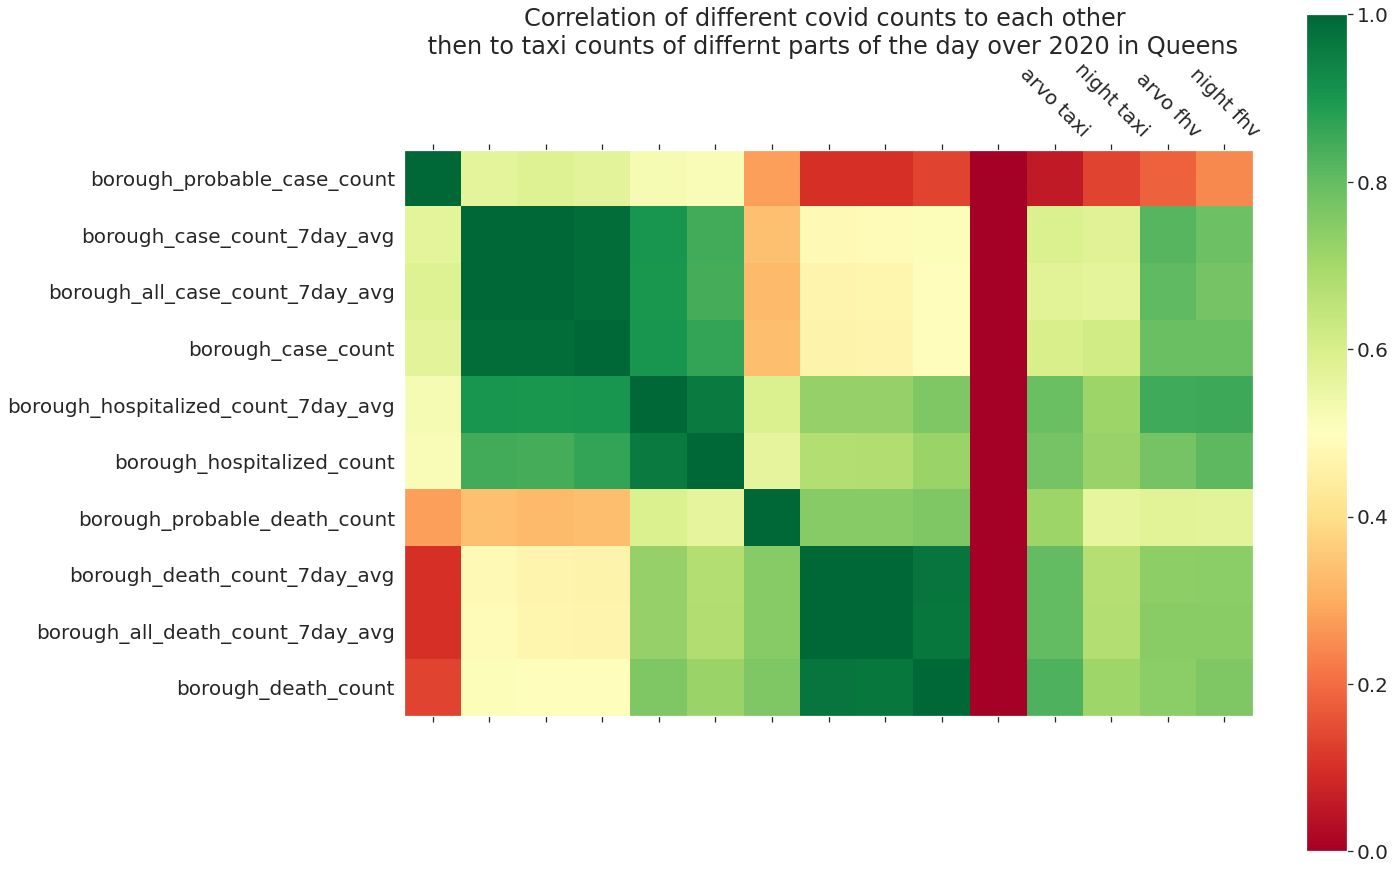

In [7]:
#extracts just the queens data
dft = df.loc[(df["borough"] == 3)]

#covid count columns in special order
covid_cols = [
     'borough_probable_case_count',
    
     'borough_case_count_7day_avg',
     'borough_all_case_count_7day_avg', 
     'borough_case_count', 
    
     'borough_hospitalized_count_7day_avg',
     'borough_hospitalized_count', 
    
     'borough_probable_death_count',
     'borough_death_count_7day_avg', 
     'borough_all_death_count_7day_avg',
     'borough_death_count', 
]



#adds time of day of interest to array
val_cols = ['2020_arvo','2020_night']
val_cols.extend(covid_cols)

#pivots data to extract the right values for plotting
dfs = dft.pivot(
    index = 'day_year', 
    columns = ['fhv'], 
    values = val_cols
)

#find correlation between covid cols and times of interest
dfs = dfs.corr()[['2020_arvo','2020_night']].drop(['2020_arvo','2020_night']).abs()

#creates one df to be just the fhvs correlations
df1 = dfs.drop(0,level="fhv").drop(0,level="fhv",axis = 1)
df1.index = df1.index.droplevel(1)
df1.columns = df1.columns.droplevel(1)

#creates another df to be just the taxis correlations
df2 = dfs.drop(1,level="fhv").drop(1,level="fhv",axis = 1)
df2.index = df2.index.droplevel(1)
df2.columns = df2.columns.droplevel(1)

#combines the data frames together
dfs = pd.concat([df1, df2], axis=1, join='inner')
dfs1 = dfs

#get inter correlation of covid count columns
dfs2 = dft[covid_cols].corr().abs()

#adds a spacing column
dfs2['space'] = pd.Series(len(covid_cols)*[0], index=dfs2.index)

#creates x labels for times of interest 
x_labs = dfs.columns
x_labs = [x_labs[x].split("_")[1] + " " + ["taxi","fhv"][x//2] for x in range(0,4)]
x_names = (len(covid_cols) + 1)*[""]
x_names.extend(x_labs)

#combines the two correlation df into one
dfs = pd.concat([dfs2, dfs1], axis=1, join='inner')

#creates figure
f = plt.figure(figsize=(19, 15))

#plots heat map of correlation
plt.matshow(dfs, fignum=f.number, vmin = 0, vmax = 1, cmap = "RdYlGn")

#sets x and y ticks and labels
plt.xticks(range(dfs.select_dtypes(['number']).shape[1]), x_names, fontsize=20, rotation=-45)
plt.yticks(range(dfs.select_dtypes(['number']).shape[0]), dfs.select_dtypes(['number']).index, fontsize=20)

#adds colour bar
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

#adds a title
plt.title('Correlation of different covid counts to each other \
\n then to taxi counts of differnt parts of the day over 2020 in Queens', fontsize=24);

In [8]:

#the following two formulas were found at
#https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# formula is covered in stats
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# quote from the page
# "Mathematically, it is defined as the weighted variance of the mean of each category divided 
# by the variance of all samples"
def correlation_ratio(measurements, categories):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta




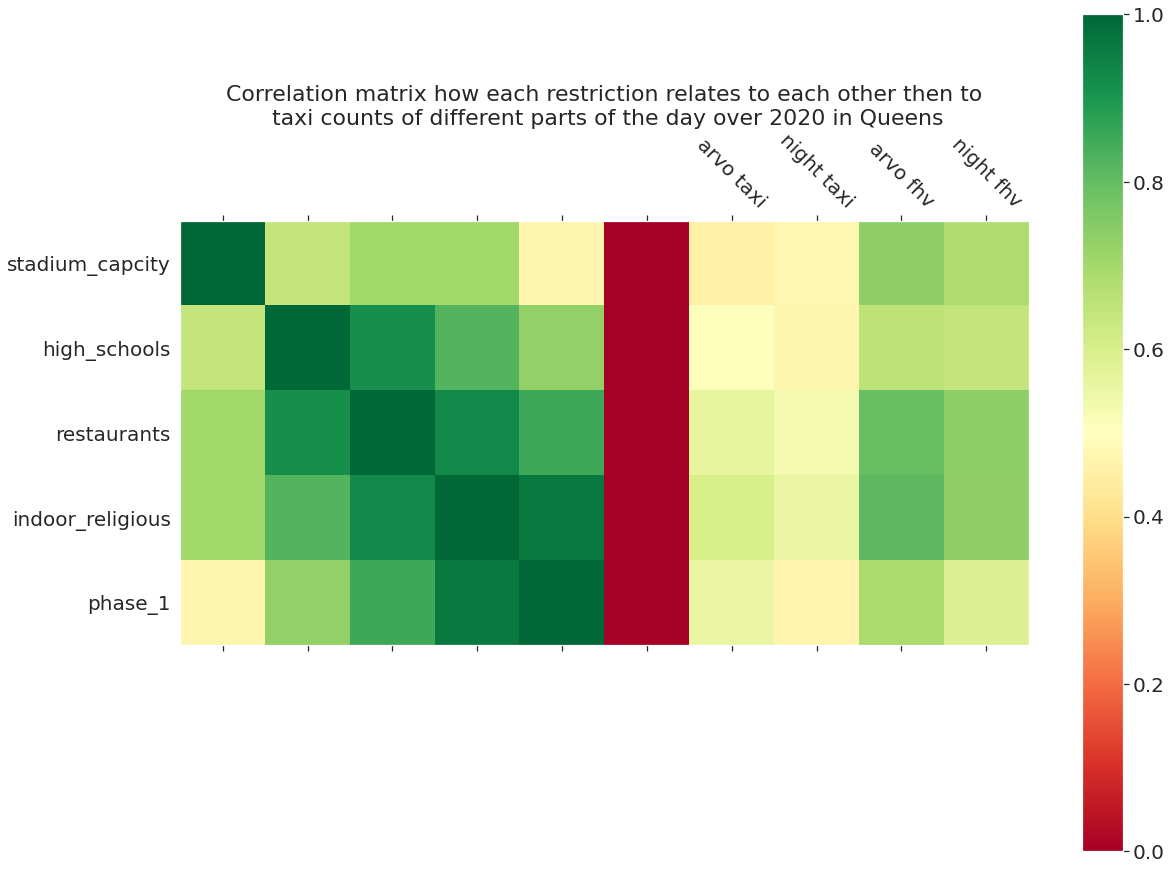

In [9]:
#name of covid columns
covid_cols = [
    "stadium_capcity", 
    "high_schools", 
    "restaurants", 
    "indoor_religious" , 
    "phase_1"
    ]

#only analysising fhv in queens
dft = df.loc[(df["borough"] == 3)]

#adds time of day of interest to array
column_temp1 = ['2020_arvo','2020_night']
column_temp1.extend(covid_cols)


#pivots data to extract the right values for plotting
dfs = dft.pivot(
    index = 'day_year', 
    columns = ['fhv'], 
    values = column_temp1
)


#finds correlation between the two
dfs = dfs.corr(method=correlation_ratio)[['2020_arvo','2020_night']].drop(['2020_arvo','2020_night']).abs()

#creates one df to be just the fhvs correlations
df1 = dfs.drop(0,level="fhv").drop(0,level="fhv",axis = 1)
df1.index = df1.index.droplevel(1)
df1.columns = df1.columns.droplevel(1)

#creates another df to be just the taxis correlations
df2 = dfs.drop(1,level="fhv").drop(1,level="fhv",axis = 1)
df2.index = df2.index.droplevel(1)
df2.columns = df2.columns.droplevel(1)

#combines the data frames together
dfs = pd.concat([df1, df2], axis=1, join='inner')
dfs1 = dfs
dfs1
#finds correlation to covid columns
dfs2 = dft[covid_cols].corr(method=cramers_v).abs()

#adds in a spacer column
dfs2['space'] = pd.Series(len(covid_cols)*[0], index = dfs2.index)

#concatinates the data frames
dfs = pd.concat([dfs2, dfs1], axis=1, join='inner')

#creates figure
f = plt.figure(figsize=(19, 15))

#plots heat map of correlation
plt.matshow(dfs, fignum=f.number, vmin = 0, vmax = 1, cmap = "RdYlGn")

#creates x labels for times of interest 
x_labs = [['arvo','night'][x%2] + " " + ["taxi","fhv"][x//2] for x in range(0,4)]
x_names = (len(covid_cols) + 1)*[""]
x_names.extend(x_labs)

#sets x and y ticks and labels
plt.xticks(range(dfs.select_dtypes(['number']).shape[1]), x_names, fontsize=20, rotation=-45)
plt.yticks(range(dfs.select_dtypes(['number']).shape[0]), dfs.select_dtypes(['number']).index, fontsize=20)

#adds colour bar
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

#adds a title
plt.title('Correlation matrix how each restriction relates to each other then to\
\n taxi counts of different parts of the day over 2020 in Queens', fontsize=22);